# Generation of a waveform using the <code>pycbc</code> library

This notebook is used to try and play with the generation of a single GW signal and detector noise.

In [1]:
import pylab
from pycbc.waveform import get_td_waveform, get_fd_waveform,td_approximants,fd_approximants
import pycbc.noise
import pycbc.psd
import pycbc
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline,interp1d

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Generate the GW signal

In [21]:
m1 = 10
m2 = 10
d = 1000
n_timesteps = 2048

params, event, signal, noise, SNR, length = [], [], [], [], [], []

hp, hc = get_td_waveform(approximant='IMRPhenomD', # generates the time-domain strains
                 mass1=m1,
                 mass2=m2,
                 delta_t=delta_t,
                 f_lower=15,
                 distance=d)

hp.start_time+=hp.duration-hp.sample_times[-1] # shifts the event so that it starts at t=0
hp.start_time-=hp.sample_times[0] 

delta_f = 1.0 / hp.duration
flen = int(n_timesteps / delta_f) + 1

psd = pycbc.psd.analytical.AdvVirgo(flen, delta_f, flow)

# generating hp.duration seconds of noise at 4096 Hz

tsamples = int(hp.duration / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)

# calculating SNR
tstilde = ts.to_frequencyseries()
snr = pycbc.filter.matched_filter(hp, tstilde, psd=psd,
                              low_frequency_cutoff=flow)
snr=np.abs(snr)

# resampling event so that it is composed of n_timesteps points and lasts 1 seconds
time_resampled = np.linspace(hp.duration-0.01-1,hp.duration-0.01,n_timesteps)
spl = interp1d(hp.sample_times, hp, kind='cubic')
event_resampled = spl(time_resampled)

spl = interp1d(ts.sample_times, ts, kind='cubic')
noise_resampled = spl(time_resampled)
signal_resampled = event_resampled + noise_resampled

sigma = np.std(noise_resampled) # std of the noise
SNR.append(np.abs(event_resampled).max()/sigma)

# normalising event, signal to the same max
event_resampled = event_resampled/1.0e-21
signal_resampled = signal_resampled/1.0e-21

#event.append(event_resampled/signal_resampled.max()) # event contains only the clean simulated event (only plus polarisation)
event.append(event_resampled) # event contains only the clean simulated event (only plus polarisation)

#signal.append(signal_resampled/signal_resampled.max()) # signal contains the event + noise
signal.append(signal_resampled) # signal contains the event + noise        

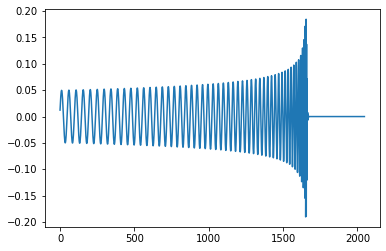

In [22]:
plt.plot(event[0])

## Generate the detector noise

In [ ]:
# The color of the noise matches a PSD which you provide
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
# psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd = pycbc.psd.analytical.AdvVirgo(flen, delta_f, flow)
# Generate 32 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(hp.duration / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)

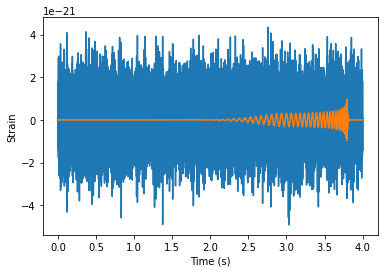

In [25]:
pylab.plot(ts.sample_times, ts+hp)
pylab.plot(hp.sample_times, hp)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()